In [4]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import h5py #For videos
import glob
import shutil
import re

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

# For multithreading support of simulations
import concurrent.futures
import time
import multiprocessing

In [5]:
def make_video_from_solution(
    solution,
    output_file=None,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                output_file=output_file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            #Return early if just saving to file
            if(output_file!=None):
                return
            video = anim.to_html5_video()
        return HTML(video)

Solving the time-dependent Ginzburg-Landau equations for an antidot system, with screening included.

In [6]:
length_units = "um"
# Material parameters
xi = 0.2
d = 0.1
big_lambda = 0.2


london_lambda = np.sqrt(d*big_lambda)


layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 3.6
total_length = 3.6
hole_radius = 0.9
# link_width = total_width / 3

film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    # .difference(right_notch, left_notch)
    .resample(401)
    # .buffer(0)
)


# Holes in the film
round_hole = (
    tdgl.Polygon("round_hole", points=circle(hole_radius ))
#     .translate(dx=total_width *0.1)
)


In [7]:
device = tdgl.Device(
    "antidot",
    layer=layer,
    film=film,
    holes=[round_hole],
    # terminals=[source, drain],
    # probe_points=probe_points,
    # length_units=length_units,
)

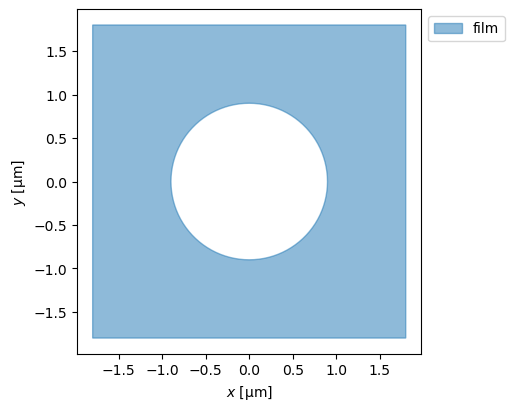

In [8]:
fig, ax = device.draw()

In [9]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|█████████████████████████████████████████████| 4036/4036 [00:03<00:00, 1186.61it/s]


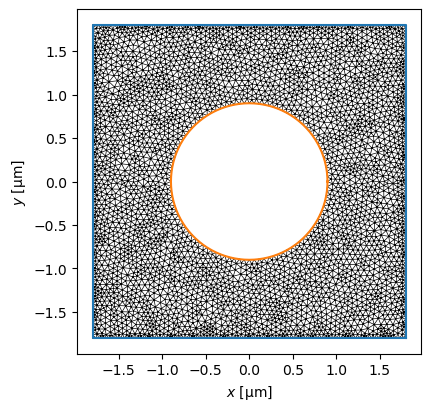

In [10]:
fig, ax = device.plot(mesh=True, legend=False)

# Setup for free energy

The function below recovers gradient vectors at mesh nodes from the vectors' projections onto mesh edges.

It assumes that the field value at each edge midpoint is approximately the mean of the field values at its endpoints (nodes)

$\mathbf{v}_{\mathrm{ node}\; i} + \mathbf{v}_{\mathrm{ node}\; j} = 2 \mathbf{v}_{\mathrm{ midpoint}\;ij}$

Multiply both sides by a unit vector parallel to the edge direction $\mathbf{e}_{ij}$

$ \mathbf{e}_{ij} \cdot \mathbf{v}_{\mathrm{ node}\; i} + \mathbf{e}_{ij} \cdot \mathbf{v}_{\mathrm{ node}\; j} = 2 \mathbf{e}_{ij} \cdot \mathbf{v}_{\mathrm{ midpoint}\;ij}$

R.h.s. is known. Equations for all edges form an overdetermined, inconsistent linear system of equations $A \vec{v} = 2 \vec{p}$.

$\vec{p}$ contains all the projection values  $ \mathbf{e}_{ij} \cdot \mathbf{v}_{\mathrm{ midpoint}\;ij}$. Length of \vec{p} is the number of edges.

We'll be solving for $\vec{v}$, which contains all vectors $\mathbf{v}_{\mathrm{ node}\; i}$. Length of  $\vec{v}$ is the number of nodes times 2 (each vector has an $x$ and $y$ component).

$A$ is a matrix whose action is equivalent to multiplying the vectors $\mathbf{v}_{\mathrm{ node}\; i}$ by $\mathbf{e}_{ij} \cdot$.

The approximate solution is found with the least squares method.



In [11]:
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr




def reconstruct_gradients(nodes, edges, projections):
    num_nodes = len(nodes)
    num_edges = len(edges)

    A = lil_matrix((num_edges, num_nodes * 2))

    for idx, (i, j) in enumerate(edges):
        P_i = nodes[i]
        P_j = nodes[j]
        edge_vector = P_j - P_i
        edge_length = np.linalg.norm(edge_vector)
        direction_vector = edge_vector / edge_length

        A[idx, 2*i:2*i+2] = direction_vector
        A[idx, 2*j:2*j+2] = direction_vector
    


    A = csr_matrix(A)
    # Solve for gradients at nodes
    result = lsqr(A, 2 * projections)[0]
    
    gradients_at_nodes = result.reshape((num_nodes, 2))
    return gradients_at_nodes

The function below is supposed to calculate 

$ F= \sum_{i \in \mathrm{nodes}} S_i \left(-\epsilon(\mathbf{r_i})  |\psi(\mathbf{r_i})|^2 + \frac{1}{2} |\psi(\mathbf{r_i})|^4 + \left| \left.(\nabla - i \mathbf{A}) \psi(\mathbf{r})\right|_{\mathbf{r}_i}   \right|^2 \right)  $ 

$S_i$ is the area of the Voronoi cell associated with the $i$-th node (which has position $\mathbf{r_i}$). The units between $\nabla$ and $\mathbf{A}$ are natural because A is given in dimensionless units .

## Possible improvements
Possibly the third term can be calculated more efficiently, without reconstructing the vectors $\mathbf{v}_{\mathrm{ node}\; i} = \left.(\nabla - i \mathbf{A}) \psi(\mathbf{r})\right|_{\mathbf{r}_i}$  at each node.

One way would be to approximate these vectors inside each Delaunay triangle. Each such vector should be determined only by three values of $\mathbf{e}_{ij} \cdot \mathbf{v}_{\mathrm{ midpoint}\;ij}$, at the three edges of the triangle.

For integration we'll need also the areas of these triangles.

In [12]:
def get_free_energy(solution):

    device = solution.device
    options = solution.options
    mesh = device.mesh
    
    psi = solution.tdgl_data.psi
    epsilon = solution.tdgl_data.epsilon
    
    ureg = device.ureg
    field_units = options.field_units
    length_units = ureg(device.length_units)
    Bc2 = device.Bc2
    applied_vector_potential = solution.tdgl_data.applied_vector_potential
    induced_vector_potential = solution.tdgl_data.induced_vector_potential
    edge_centers = device.mesh.edge_mesh.centers
    z0 = device.layer.z0

    f1=np.sum(  (-epsilon * np.abs(psi)**2 +  0.5*np.abs(psi)**4)*mesh.areas  )
    
    covariant_gradient_operator = tdgl.finite_volume.operators.build_gradient(mesh,link_exponents = applied_vector_potential+induced_vector_potential)
    
    covariant_gradient_at_edges = covariant_gradient_operator @ psi

    covariant_gradient_at_nodes = reconstruct_gradients(mesh.sites, mesh.edge_mesh.edges, covariant_gradient_at_edges ) 

    f2 = np.sum(np.linalg.norm(covariant_gradient_at_nodes,axis=1)**2 *mesh.areas)

    return f1+f2

# Solution

First, a solution without screening is found, only to serve as a seed solution for the simulation with screening.

The magnetic field in the 'no_screening' calculation is determining the phase winding of $\psi$ in the seed solution.

The magnetic field in the 'w_screening' calculation is supposed to be the magnetic field in the actual simulated system.

In [13]:
field_value_no_screening = 0.8
field_value_w_screening = 0.8

In [14]:
# This generates a radially symmetric function for psi using psi(r) and the desired number of vortices.
# It could very easily be replaced to a non-symmetric function
# The other degree of freedom is the mu_boundary that is currently left as zero like the default.
def psi_ansatz(center, vortex_count, psi_radial, points):
    #Note that x, y coordinates and center coordinates must be given in dimensionless coordinates
    x_center = center[0]
    y_center = center[1]
    x = points[:, 0]
    y = points[:, 1]
    phi = np.arctan2((y-y_center),(x-x_center))
    r = np.sqrt((x-x_center)**2 + (y-y_center)**2)
    return np.exp(vortex_count*1j*phi) * psi_radial(r)

def generate_ansatz(device, options, applied_vector_potential, center, vortex_count, psi_radial):
    # This runs a short (time=1) simulation to generate a Solution object easily.
    # This could be done other ways too, but this is short and larger modifications
    # would be better left to the package itself.
    # It then edits the TDGLData object
    
    print("Solving 1 time step to generate most of solution object")
    initial_options = tdgl.SolverOptions(
        solve_time=1,
        field_units = options.field_units,
        current_units = options.current_units,
    )
    solution = tdgl.solve(
        device=device,
        options=initial_options,
        applied_vector_potential=applied_vector_potential,
    )
    
    print("Calculating Replacement TDGLData")
    
    # Directly create a solver to reuse the ability to calculate mu, super_current, and normal current
    # I would use the one that was used in tdgl.solve but it is not returned. It would be easy to edit
    # the package so that the solver is returned for situations like this. the defaults are copied from
    # Solve.py.  solve_for_observables references some built in properties of the solver: default options, operators, 
    # and mu_boundary. The default options are clearly okay to reference. The operators that are referenced
    # are not changed after they are set during initialization assuming that A remains zero.  This means that the
    # operators are initialized properly for when solver.solve_for_observables is called.
    # solver.mu_boundary is the only parameter that may need to be set, but since no current is flowing into
    # or out of the device, I think it is fair to leave it as it is initialized.  mu_boundary is typically all
    # zero and remains zero when no current is applied.
    
    solver = tdgl.solver.solver.TDGLSolver(
        device=device,
        options=options,
        applied_vector_potential=applied_vector_potential,
        terminal_currents=None,
        disorder_epsilon=1,
        seed_solution=None,
    )
    
    new_psi = psi_ansatz(center, vortex_count, psi_radial, solution.device.mesh.sites)
    new_mu, new_supercurrent, new_normal_current = solver.solve_for_observables(psi=new_psi, dA_dt=0)
    
    replacement_data = tdgl.solution.data.TDGLData(
        step=-1,  #Last step
        epsilon=solution.tdgl_data.epsilon, #Leave the same since this is just a physical parameter
        psi=new_psi, #This directly uses the psi_ansatz function defined above
        mu=new_mu, # Calculated using new_psi
        applied_vector_potential=applied_vector_potential, # User Parameter
        induced_vector_potential=np.zeros((len(solution.device.mesh.edge_mesh.edges), 2)), # No screening current, this is zero until a solve step screening is performed  
        supercurrent=new_supercurrent, # Calculated using new_psi
        normal_current=new_normal_current, # Calculated using new_psi
        state=solution.tdgl_data.state, # This should be fine to leave as-is. It just contains {'dt', 'step', 'time', 'timestamp'}
    )
    
    print("Replacing TDGLData")
    solution.tdgl_data = replacement_data
    
    print("Finished Calculating Ansatz")
    return solution
    

In [15]:
def recalculate_solution_with_screening(field_strength, initial_vortex_count, seed_solution, save_file):

    options_with_screening = tdgl.SolverOptions(
        solve_time=10,
        field_units = "mT",
        current_units="uA",
        output_file=save_file,
        save_every=800,
        include_screening=True,
    )

    try:
        solution = tdgl.Solution.from_hdf5(save_file)
        print("Screening Solution Already Exists")
    except FileNotFoundError as e:
        print("Screening solution not found. Solving.")

        solution = tdgl.solve(
            device,
            options=options_with_screening,
            applied_vector_potential=field_strength,
            seed_solution=seed_solution,
        )
    return solution

# Generate solutions for a specified range of B fields and quantitizations

In [22]:
# Define the function you want to call
def simulate(initial_vortex_count, field_strength):
    print(f"Starting simulation for N={initial_vortex_count}, B={field_strength}")
    initial_vortex_count = round(initial_vortex_count, 0)
    field_strength = round(field_strength, 3)
    save_file = os.getcwd() + "/solutions/solution_" + str(initial_vortex_count) + "_" + str(field_strength) + ".h5"
    
    if os.path.exists(save_file):
        # os.rem
        ove(save_file)
        return
    
    options_no_screening = tdgl.SolverOptions(
        solve_time=100,
        field_units = "mT",
        current_units="uA",
    )
    
    ansatz = generate_ansatz(
        device=device,
        options=options_no_screening,
        applied_vector_potential=field_strength,#Set this to be what you want to test after generating the ansatz
        center=(0,0),
        vortex_count=initial_vortex_count,
        psi_radial= lambda r: 1 ,
    )
    
    no_screening_solution = tdgl.solve(
        device,
        options_no_screening,
        applied_vector_potential=field_value_no_screening,
        seed_solution=ansatz,
    )
    
    recalculate_solution_with_screening(field_strength, initial_vortex_count, no_screening_solution, save_file)
    return f"Finished processing (count={initial_vortex_count}, field={field_strength})"


In [ ]:
vortex_counts_to_simulate = [-2,-1,0,1,2]
fields_to_simulate = np.linspace(-1, 1, 20)
max_workers = 4 # Number of different simulations to run simultaneously
timeout_duration = 60 * 30  # in seconds, 30 minutes

# Number of parallel workers
max_workers = 5

# Timeout duration for each task (in seconds)
timeout_duration = 1  # Set a short timeout for demonstration

# Use ThreadPoolExecutor to manage multiple tasks with a timeout
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Create future objects for all function calls (i, j) in range(3)
    futures = {executor.submit(simulate, i, j): (i, j) for i in vortex_counts_to_simulate for j in fields_to_simulate}
    
    # Iterate over the completed future objects
    for future in concurrent.futures.as_completed(futures):
        i, j = futures[future]
        try:
            # Wait for the result with a timeout
            result = future.result(timeout=timeout_duration)
            print(result)
        except concurrent.futures.TimeoutError:
            print(f"Timeout occurred for ({i}, {j}) after {timeout_duration} seconds.")
        except Exception as e:
            print(f"Error in processing ({i}, {j}): {e}")


Starting simulation for N=-2, B=-1.0
Starting simulation for N=-2, B=-0.8947368421052632
Starting simulation for N=-2, B=-0.7894736842105263
Solving 1 time step to generate most of solution object
Solving 1 time step to generate most of solution object
Solving 1 time step to generate most of solution object
Starting simulation for N=-2, B=-0.6842105263157895
Starting simulation for N=-2, B=-0.5789473684210527
Solving 1 time step to generate most of solution object
Solving 1 time step to generate most of solution object


Simulating:   0%|                                                                              | 0/1 [00:00<?, ?tau/s ]

Simulating:   0%|                                                                              | 0/1 [00:00<?, ?tau/s ]


Simulating:   0%|                                                                              | 0/1 [00:00<?, ?tau/s ]



Simulating:   0%|                                                                 | 0/1 [00:00<3:07:08, 11228.88s/tau ]

Simulating:   0%|                                                                  | 0/1 [00:00<2:37:50, 9470.14s/tau ]


Simulating:   0%|                                                                  | 0/1 [00:00<2:27:08, 8828.64s/tau ]



Simulating:  20%|██████████████▏                                                       | 0/1 [00:00<00:00,  1.14tau/s ]

Simulating:  20%|██████████████                                                        | 0/1 [00:00<00:00,  1.12tau/s ]


Simulating:  20%|████████

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating:  99%|█████████████████████████████████████████████████████████████████████▍| 1/1 [00:01<00:00,  1.72s/tau ]




Simulating:  72%|██████████████████████████████████████████████████▌                   | 1/1 [00:01<00:00,  2.33s/tau ]

Simulating:  80%|███████████████████████████████████████████████████████▉              | 1/1 [00:01<00:00,  2.05s/tau ]



Simulating:  98%|████████████████████████████████████████████████████████████████████▊ | 1/1 [00:01<00:00,  1.66s/tau ]

Simulating:  79%|██████████████████████████████████████████████████████▉               | 1/1 [00:01<00:00,  2.15s/tau ]

Calculating Replacement TDGLData



Simulating:  99%|█████████████████████████████████████████████████████████████████████▌| 1/1 [00:01<00:00,  1.96s/tau ]

Simulating:   0%|                                                               | 0/10 [00:00<48:04:22, 17306.25s/tau ]



Replacing TDGLData
Finished Calculating Ansatz


Simulating:   2%|█▍                                                                   | 0/10 [00:00<00:08,  1.16tau/s ]

Simulating:  93%|█████████████████████████████████████████████████████████████████▍    | 1/1 [00:02<00:00,  2.52s/tau ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz




Simulating:  99%|█████████████████████████████████████████████████████████████████████▍| 1/1 [00:02<00:00,  2.28s/tau ]

Simulating:  99%|█████████████████████████████████████████████████████████████████████▌| 1/1 [00:02<00:00,  2.55s/tau ]


Simulating:   2%|█▍                                                                   | 0/10 [00:00<00:08,  1.14tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz


Simulating:   2%|█                                                                    | 0/10 [00:00<00:06,  1.48tau/s ]

Calculating Replacement TDGLData
Replacing TDGLData
Finished Calculating Ansatz





Simulating:   0%|                                                                             | 0/10 [00:00<?, ?tau/s ]


Simulating:   1%|▋                                                                    | 0/10 [00:00<00:10,  1.01s/tau ]



Simulating:   0%|                                                                             | 0/10 [00:00<?, ?tau/s ]


Simulating:   2%|█▍                                                                   | 0/10 [00:00<00:09,  1.00s/tau ]



Simulating:   4%|██▋                                                                  | 0/10 [00:01<00:38,  4.06s/tau ]

Simulating:   5%|███▍                                                                 | 0/10 [00:01<00:30,  3.25s/tau ]

Simulating:   6%|███▊                                                                 | 1/10 [00:01<00:27,  2.96s/tau ]

Simulating:   4%|██▌                                                                  | 0/10 [00:01<00:34,  3.62s/tau ]


Simulating:   6%|████▏

# Calculate Free energy for each of the solutions

In [56]:
energies = []
for save_file in (glob.glob(os.getcwd() + "/solutions/*")):
    n = save_file.split('\\')[-1].split("_")[1]
    field = save_file.split("\\")[-1].split("_")[2][:-3]
    print(f"Evaluating for N={n} and Field={field}")
    try:
        solution = tdgl.Solution.from_hdf5(save_file)
        energy = get_free_energy(solution)
        energies.append((n,field,energy))
        print(energy)
    except Exception as e:
        print(e)
        print("This was probably due to a timeout")


Evaluating for N=-1 and Field=-0.25
"Unable to open object (object 'solution' doesn't exist)"
This was probably due to a timeout
Evaluating for N=-1 and Field=-0.5
"Unable to open object (object 'solution' doesn't exist)"
This was probably due to a timeout
Evaluating for N=-1 and Field=-0.75
-127.3174705118415
Evaluating for N=-1 and Field=-1.0
-124.24548866280861
Evaluating for N=-1 and Field=0.0
-129.32855053256895
Evaluating for N=-1 and Field=0.25
-127.66838497768364
Evaluating for N=-1 and Field=0.5
-124.79823883985067
Evaluating for N=-1 and Field=0.75
-120.63498816786566
Evaluating for N=-1 and Field=1.0
-115.04454818071763
Evaluating for N=0 and Field=-0.25
-129.6287251656972
Evaluating for N=0 and Field=-0.5
-127.90653722891872
Evaluating for N=0 and Field=-0.75
-124.99229361233373
Evaluating for N=0 and Field=-1.0
-120.81543117989769
Evaluating for N=0 and Field=0.0
"Unable to open object (object 'solution' doesn't exist)"
This was probably due to a timeout
Evaluating for N=0

Text(0, 0.5, 'Free Energy')

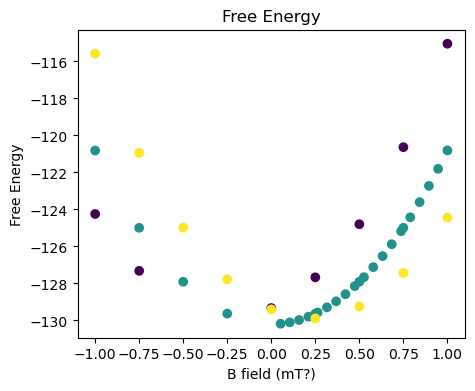

In [61]:
ns = []
fields = []
energy_vals = []

for pt in energies:
    ns.append(int(pt[0]))
    fields.append(float(pt[1]))
    energy_vals.append(pt[2])

plt.scatter(fields, energy_vals, c=ns, cmap="viridis")
plt.title("Free Energy")
plt.xlabel("B field (mT?)")
plt.ylabel("Free Energy")

# Generate Videos of each of the solutions

In [44]:
solutions_folder_path = os.getcwd() + "/solutions/"
file_pattern = os.path.join(solutions_folder_path, "solution_*.h5")
files = glob.glob(file_pattern)

for file in files:
    file_name = os.path.basename(file)

    match = re.match(r"solution_(-?\d+)_(-?\d+\.?\d*)\.h5", file_name)
    if match:
        initial_vortex_count = int(match.group(1))
        field_strength = float(match.group(2))
        try:
            solution = tdgl.Solution.from_hdf5(file)
        
            video_filename = os.getcwd() + "/videos/video_" + str(initial_vortex_count) + "_" + str(field_strength) + ".mp4"
            if(not(os.path.exists(video_filename))):
                print(f"Generating Video (Vortex count: {initial_vortex_count}, Field strength: {field_strength})")
                make_video_from_solution(solution, output_file=video_filename)
            else:
                print(f"Skipping video generation, video already exists (Vortex count: {initial_vortex_count}, Field strength: {field_strength})")
        except Exception as e:
            print(e)
    else:
        print(f"File {file_name} does not match the expected pattern.")



"Unable to open object (object 'solution' doesn't exist)"
Generating Video (Vortex count: -1, Field strength: -1.0)


Saving to video_-1_-1.0.mp4: 100%|███████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14frames/s]


Generating Video (Vortex count: -1, Field strength: 0.0)


Saving to video_-1_0.0.mp4: 100%|████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11frames/s]


Generating Video (Vortex count: -1, Field strength: 0.5)


Saving to video_-1_0.5.mp4: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/frames]


Generating Video (Vortex count: -1, Field strength: 1.0)


Saving to video_-1_1.0.mp4: 100%|████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/frames]


Generating Video (Vortex count: 0, Field strength: -0.5)


Saving to video_0_-0.5.mp4: 100%|████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/frames]


Generating Video (Vortex count: 0, Field strength: -1.0)


Saving to video_0_-1.0.mp4: 100%|████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/frames]


"Unable to open object (object 'solution' doesn't exist)"
Generating Video (Vortex count: 0, Field strength: 0.5)


Saving to video_0_0.5.mp4: 100%|█████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/frames]


Generating Video (Vortex count: 0, Field strength: 1.0)


Saving to video_0_1.0.mp4: 100%|█████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/frames]


Generating Video (Vortex count: 1, Field strength: -0.5)


Saving to video_1_-0.5.mp4: 100%|████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/frames]


Generating Video (Vortex count: 1, Field strength: -1.0)


Saving to video_1_-1.0.mp4: 100%|████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/frames]


Generating Video (Vortex count: 1, Field strength: 0.0)


Saving to video_1_0.0.mp4: 100%|█████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/frames]


Generating Video (Vortex count: 1, Field strength: 0.5)


Saving to video_1_0.5.mp4: 100%|█████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/frames]


Generating Video (Vortex count: 1, Field strength: 1.0)


Saving to video_1_1.0.mp4: 100%|█████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/frames]


In [ ]:
plt.scatter(fields, energies, c=vortex_counts)
plt.xlabel("Applied Field (mT)")
plt.ylabel("Free Energy (No F0, H terms, units of terms?)")
plt.title("Free energy of Different vortex numbers")

In [ ]:
import random
project_name = "J7_antidot"
no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"
stable_no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"
screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"
stable_screening_folder    = os.getcwd() + "/solutions/" + project_name + "/stable_screening/"

jump_files = set(os.listdir(stable_screening_folder)) #- set(os.listdir(screening_folder))

# print(jump_files)

jump_filename = random.choice(list(jump_files))

solution = tdgl.Solution.from_hdf5(stable_screening_folder + jump_filename)

# video_filename = os.getcwd() + "/videos/" + project_name + "/no_screening/" + jump_filename[:-3] + ".mp4"
# if not(os.path.exists(video_filename)):
#     make_video_from_solution(solution, output_file=video_filename)
    
jump_times = []
jump_energies = []

solution = tdgl.Solution.from_hdf5(stable_screening_folder + jump_filename)
for time in np.linspace(0,10,10):
    solution.solve_step = solution.closest_solve_step(time)
    energy = get_free_energy(solution)
    jump_energies.append(energy)
    jump_times.append(time)
    print(f"time: {round(time,2)}, Energy: {round(energy,3)}")

In [ ]:
plt.scatter(jump_times[1:], jump_energies[1:])
plt.xlabel("time")
plt.ylabel("Energy")
plt.show()
